In [2]:
import os
import numpy as np
from utils import Identity, compute_identity_stats, read_json, generate_esm2_embeddings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"])

In [4]:
if not os.path.exists(".cache/figs"):
    os.makedirs(".cache/figs")

In [5]:
MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 100

# Load data

In [6]:
# fasta = read_fasta("../data/build/dataset.fasta")
data = read_json("../data/build/dataset.json")
dataset = [int(sample["ID"]) for sample in data if MIN_SEQ_LEN <= len(sample["Sequence"]) <= MAX_SEQ_LEN]

# Split the data into two subsets

In [7]:
indices = np.arange(len(dataset))
np.random.shuffle(indices)
test_indices = indices[:int(len(dataset) * 0.2)]
train_indices = indices[int(len(dataset) * 0.2):]
train_ids = [dataset[i] for i in train_indices]
test_ids = [dataset[i] for i in test_indices]

# Assert independence between training and test sets

In [8]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|████████████████████████████████████|  3804/3804 [00:23<00:00, 122.18it/s] 


In [9]:
test2train_id = identities.max(axis=1)

Max identity: 1.0
Mean identity: 0.8563264998357132
Median identity: 0.9166666666666666
Quantiles:
- 0.01 quantile: 0.375
- 0.05 quantile: 0.47368421052631576
- 0.10 quantile: 0.6
- 0.25 quantile: 0.8
- 0.50 quantile: 0.9166666666666666
- 0.75 quantile: 0.9683779761904762
- 0.90 quantile: 1.0
- 0.95 quantile: 1.0
- 0.99 quantile: 1.0
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
2227


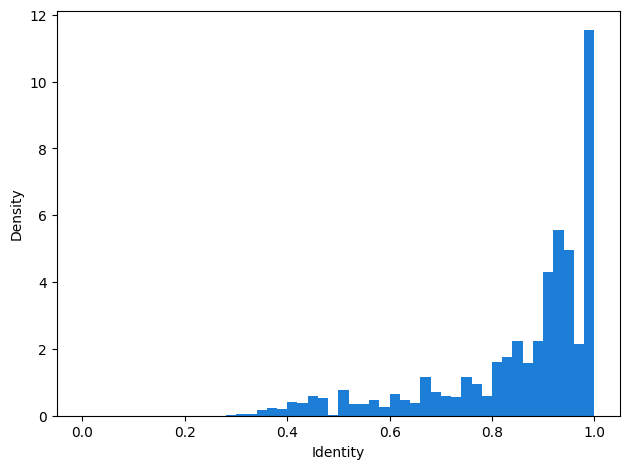

In [10]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
# plt.title("Highest identity between each test sequence and all train sequences")
plt.tight_layout()
plt.savefig(".cache/figs/random_split.svg")

In [12]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 15218


In [32]:
# Get train/test sequences
train_seqs = [sample["Sequence"] for sample in data if sample["ID"] in train_ids]
test_seqs = [sample["Sequence"] for sample in data if sample["ID"] in test_ids]
# Get train/test e coli MIC
train_mic = [sample["Targets"].get("Escherichia coli", (None, ))[0] for sample in data if sample["ID"] in train_ids]
test_mic = [sample["Targets"].get("Escherichia coli", (None, ))[0] for sample in data if sample["ID"] in test_ids]
train_mask = [mic is not None for mic in train_mic]
test_mask = [mic is not None for mic in test_mic]
train_seqs = [seq for seq, mask in zip(train_seqs, train_mask) if mask]
test_seqs = [seq for seq, mask in zip(test_seqs, test_mask) if mask]
train_mic = np.array([mic for mic in train_mic if mic is not None])
test_mic = np.array([mic for mic in test_mic if mic is not None])

# Generate train/test embeddings
train_X = generate_esm2_embeddings(train_seqs, batch_size=128, device="mps")
test_X = generate_esm2_embeddings(test_seqs, batch_size=128, device="mps")
# Train a linear regression model
model = LinearRegression().fit(train_X, np.log10(train_mic))
# Evaluate the model
test_pred = model.predict(test_X)
pcc = pearsonr(test_pred, np.log10(test_mic)).statistic
pcc

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|██████████████████████████████████████████|  86/86 [07:49<00:00, 5.24s/it] 


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|██████████████████████████████████████████|  22/22 [02:09<00:00, 5.53s/it] 


np.float64(0.626055966634892)